## User Behavior Analysis Tao Bao 
WORK IN PROGRESS

### Dataset Background

Dataset of user behaviors from Taobao, for recommendation problem with implicit feedback. The dataset is offered by Alibaba. Data is randomly selected from 1 million users who have behaviors including click, purchase, adding item to shopping cart and item favoring during November 25 to December 03, 2017. The dataset is organized in a very similar form to MovieLens-20M, i.e., each line represents a specific user-item interaction, which consists of user ID, item ID, item's category ID, behavior type and timestamp, separated by commas.

User ID	- An integer, the serialized ID that represents a user  
Item ID	- An integer, the serialized ID that represents an item  
Category ID	- An integer, the serialized ID that represents the category which the corresponding item belongs to  
Behavior type - A string, enum-type from ('pv', 'buy', 'cart', 'fav')  
Timestamp - An integer, the timestamp of the behavior


This data set contains all the behaviors of about one million random users with behaviors between November 25, 2017 and December 3, 2017


In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import squarify as sq
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

### Data Preprocessing

In [2]:
#For purpose of this exercise using on 1/10th of the data

data_v1 = pd.read_csv('UserBehavior.csv', header=0)
data_v1 = data_v1[:1050000]
data_v1.head()

,1,2268318,2520377,pv,1511544070
0,1,2333346,2520771,pv,1511561733
1,1,2576651,149192,pv,1511572885
2,1,3830808,4181361,pv,1511593493
3,1,4365585,2520377,pv,1511596146
4,1,4606018,2735466,pv,1511616481


In [4]:
data_v1.columns = ['userid', 'itemid', 'catid', 'behavior', 'timestamp']
data_v1.head()

,userid,itemid,catid,behavior,timestamp
0,1,2333346,2520771,pv,1511561733
1,1,2576651,149192,pv,1511572885
2,1,3830808,4181361,pv,1511593493
3,1,4365585,2520377,pv,1511596146
4,1,4606018,2735466,pv,1511616481


In [5]:
# data_temp['timestamp'] = pd.to_datetime(data_temp['timestamp'].values, utc = True, unit='s', format = '%Y-%m-%d').tz_convert('Asia/Shanghai')
data_v1['timestamp']=pd.to_datetime(data_v1.timestamp.values,unit='s',utc=True).tz_convert('Asia/Shanghai')
data_v1.head()

,userid,itemid,catid,behavior,timestamp
0,1,2333346,2520771,pv,2017-11-25 06:15:33+08:00
1,1,2576651,149192,pv,2017-11-25 09:21:25+08:00
2,1,3830808,4181361,pv,2017-11-25 15:04:53+08:00
3,1,4365585,2520377,pv,2017-11-25 15:49:06+08:00
4,1,4606018,2735466,pv,2017-11-25 21:28:01+08:00


In [6]:
data_v1['date'] = data_v1['timestamp'].dt.date
data_v1['day'] = data_v1['timestamp'].dt.day
data_v1['month'] = data_v1['timestamp'].dt.month
data_v1['hour'] = data_v1['timestamp'].dt.hour
data_v1.head()

data_v1['date'] = pd.to_datetime(data_v1['date'])  
#Remove data outside of the range (November 25, 2017 and December 3, 2017)
data_v1 = data_v1.loc[(data_v1['date'] > '2017-11-25') & (data_v1['date'] <= '2017-12-03')]

In [7]:
data_v1.tail()

,userid,itemid,catid,behavior,timestamp,date,day,month,hour
1049995,130802,4369375,3002561,pv,2017-12-03 22:49:09+08:00,2017-12-03,3,12,22
1049996,130802,256383,4708262,pv,2017-12-03 22:50:42+08:00,2017-12-03,3,12,22
1049997,130802,2941750,3002561,pv,2017-12-03 22:51:03+08:00,2017-12-03,3,12,22
1049998,130802,892908,3002561,pv,2017-12-03 22:53:26+08:00,2017-12-03,3,12,22
1049999,130802,2719022,3002561,pv,2017-12-03 22:53:53+08:00,2017-12-03,3,12,22


In [ ]:
# 1. Find unique userid, itemid
# 2. Find unique userid at each step of the user funnel
# 3. Find conversion ratio from pv-fav fav-cart cart-buy fav-buy
# 4. Find which month has the highest ratio 
# 5. Visualize day, month, hour where ratios and absolutes are the highest
# 6. Time series


In [ ]:
n = data_v1.nunique(axis=0)
  
print("No.of.unique values in each column:\n",n)

In [63]:
query = data_v1.groupby('behavior')['userid'].nunique()
query = query.reset_index()
query

,behavior,userid
0,buy,6725
1,cart,7507
2,fav,3914
3,pv,10179


### Sales Funnel
pv - Page view of an item's detail page, equivalent to an item click  
fav - Favor an item  
cart - Add an item to shopping cart  
buy - Purchase an item  

In [98]:
query = data_v1.groupby('behavior')['userid'].count()
query = query.reset_index()
query = query.sort_values(by='userid', ascending=False)

fig = px.funnel(query, x='userid', y='behavior')
fig.show()

In [64]:
#Not Unique
query = data_v1.groupby('behavior')['userid'].count()
query = query.reset_index()
query['ratio_to_buy'] = query.loc[0, 'userid'] / query['userid']  
query = query.sort_values(by='userid')
query


,behavior,userid,ratio_to_buy
0,buy,19254,1.000000
2,fav,26534,0.725635
1,cart,51901,0.370976
3,pv,842198,0.022862


In [25]:
#Time Series Date
def function(x, arg):
    d = {}
    d['viewCount'] = x.groupby(arg)['behavior'].apply(lambda x: (x=='pv').sum()).iloc[0]
    d['favCount'] = x.groupby(arg)['behavior'].apply(lambda x: (x=='fav').sum()).iloc[0]
    d['cartCount'] = x.groupby(arg)['behavior'].apply(lambda x: (x=='cart').sum()).iloc[0]
    d['buyCount'] = x.groupby(arg)['behavior'].apply(lambda x: (x=='buy').sum()).iloc[0]
#     d['favourite_count'] = x['b'].mean()
#     d['cart_count'] = (x['c'] * x['d']).sum()
#     d['buy_count'] = (x['c'] * x['d']).sum()
    x = x.reset_index()
    return pd.Series(d, index=['viewCount', 'favCount', 'cartCount', 'buyCount'])


data_datetimeseries= data_v1.groupby('date').apply(function,arg ='date')
data_datetimeseries


,viewCount,favCount,cartCount,buyCount
date,,,,
2017-11-26,100677,3235,6051,2109
2017-11-27,91678,2977,5699,2336
2017-11-28,93034,2843,5782,2310
2017-11-29,95787,3177,5802,2404
2017-11-30,99713,3041,5906,2447
2017-12-01,102674,3145,6337,2262
2017-12-02,129690,4112,8205,2649
2017-12-03,128945,4004,8119,2737


### Date Time Series Analysis

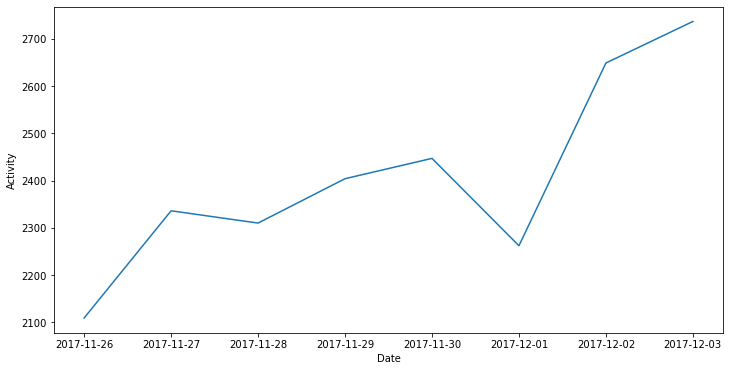

In [27]:
#d['user_id_count'] = x.groupby('date')['userid'].count().iloc[0]
# Date = data_datetimeseries['date']
ViewCount = data_datetimeseries['viewCount'] 
FavCount = data_datetimeseries['favCount']
BuyCount = data_datetimeseries['buyCount']

plt.figure(figsize=(12,6))
# plt.plot(data_datetimeseries.index, ViewCount)
plt.plot(data_datetimeseries.index, BuyCount)
plt.title('')
plt.xlabel('Date')
plt.ylabel('Activity')
plt.show()


- User traffic skyrockets on the weekends
- Marketing efforts should be concentrated during the weekends where traffic and purchase volume are at its peak

### Correlation Plot of Behavior Variables

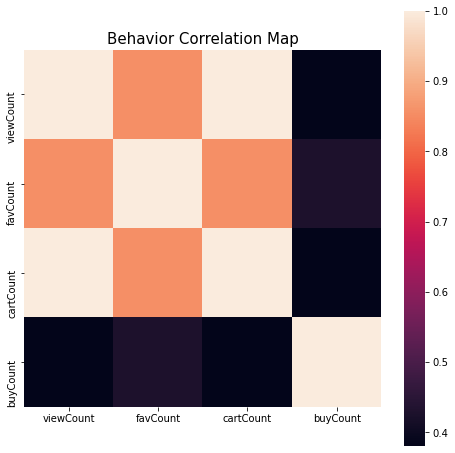

In [156]:
corrmat = data_datetimeseries.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Behavior Correlation Map", fontsize=15)
plt.show()

### Hourly Time Series Analysis

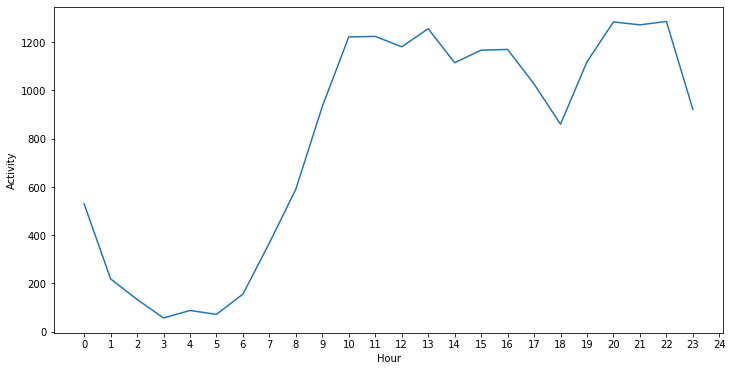

In [29]:
data_hourlytimeseries= data_v1.groupby('hour').apply(function,arg ='hour')

ViewCount = data_hourlytimeseries['viewCount']
FavCount = data_hourlytimeseries['favCount']
BuyCount = data_hourlytimeseries['buyCount']

plt.figure(figsize=(12,6))
# plt.plot(data_datetimeseries.index, ViewCount)
plt.plot(data_hourlytimeseries.index, BuyCount)
plt.title('')
plt.xlabel('Hour')
plt.ylabel('Activity')
plt.xticks(np.arange(0, len(data_hourlytimeseries.index)+1, 1))
plt.show()


<!-- The activity of users is low from 1:00 to 6:00 every day, which is in line with most people's work and rest time; at 7:00, the number of users' visits and the number of visitors began to recover slowly; the user's activity was relatively stable between 10:00 and 17:00; the number of users began to surge at 18:00, and reached the highest value in the day (21:00-22:00), which is the most active time of users.

As can be seen from the above figure, businesses should concentrate resources and focus on drainage and marketing activities in the evening (18:00-23:00). -->



- The activity of users is low from 1:00 to 6:00 every day, which is in line with most people's work and rest time; at 7:00, the number of users' visits and the number of visitors began to recover slowly; the user's activity was relatively stable between 10:00 and 17:00; the number of users began to surge at 18:00, and reached the highest value in the day (21:00-22:00), which is the most active time of users.

- As can be seen from the above figure, businesses should concentrate resources and focus on drainage and marketing activities in the evening (18:00-23:00).

### Repurchase Frequencies

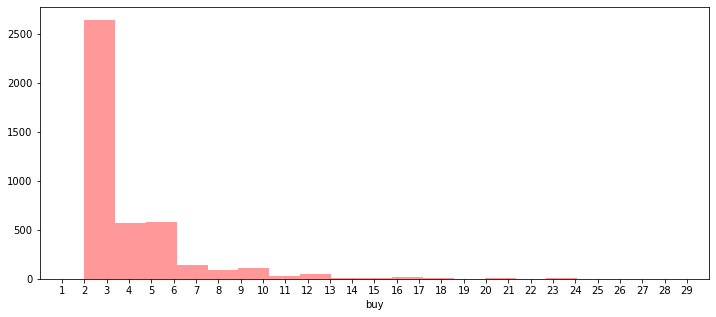

In [126]:
query = data_v1.groupby(by='userid').behavior.value_counts().unstack()
query = query[query['buy'] >= 2]['buy']
query


#Distrbution
plt.figure(figsize=(12,5))
sns.distplot(query,kde=False, color = 'Red').set(xticks=np.arange(1,30,1))
plt.xlim(0, 30)
plt.show()

### Repurchase Rate - (Unique userid that purchased the same itemid more than once)

In [121]:
#Repurchase Rate - (Unique userid that purchased the same itemid more than once)
user_bought_count = data_v1[data_v1['behavior']=='buy'].userid.nunique()
repurchase_rate = (query.count()/user_bought_count)*100
print('The repurchase rate is ' + format(repurchase_rate) + ' %')

The repurchase rate is 63.64312267657992 %


- As stated by the above output, the repurchase rate of users is 63.6%, meaning out of 100 customers around 63 to 64 customers would repurchase a second or more items after their first, indicating that the quality of Taobao users is relatively high. However most repurchases reside in the second purchase.

### Top 10 Product Categories with the most Purchases

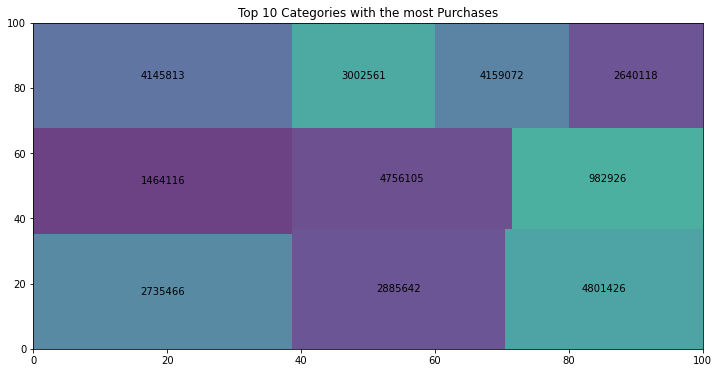

In [159]:
query = data_v1[data_v1['behavior'] =='buy'].groupby(['catid']).size().reset_index(name='behavior_count') 
query = query.sort_values(by=['behavior_count'], ascending = False)
query


plt.figure(figsize=(12,6))
sq.plot(sizes=query['behavior_count'].head(10), label=query['catid'], alpha=.8 )
plt.title('Top 10 Categories with the most Purchases')
plt.show()

### Top 10 Product Categories with the most Page Views

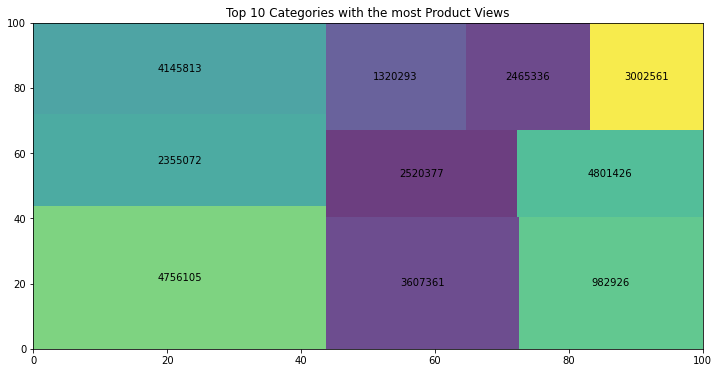

In [161]:
query = data_v1[data_v1['behavior'] =='pv'].groupby(['catid']).size().reset_index(name='behavior_count') 
query = query.sort_values(by=['behavior_count'], ascending = False)
query

plt.figure(figsize=(12,6))
sq.plot(sizes=query['behavior_count'].head(10), label=query['catid'], alpha=.8 )
plt.title('Top 10 Categories with the most Product Views')
plt.show()

In [163]:
#Top 10 unique userid purchase volume and rate
query = data_v1.groupby(by='itemid').behavior.value_counts().unstack()
query.replace(to_replace=np.nan, value=0, inplace=True)
query['buy/pv'] = query['buy']/query['pv']
# query = query[query['buy/pv'] > 0]

# query = query.sort_values(by=['buy/pv'], ascending = False)
query.head(10)

behavior,buy,cart,fav,pv,buy/pv
itemid,,,,,
72,0.0,0.0,0.0,1.0,0.000000
81,1.0,1.0,0.0,13.0,0.076923
87,0.0,0.0,0.0,1.0,0.000000
101,0.0,0.0,0.0,2.0,0.000000
115,0.0,0.0,0.0,4.0,0.000000
122,0.0,0.0,0.0,1.0,0.000000
176,0.0,0.0,0.0,1.0,0.000000
190,0.0,0.0,0.0,1.0,0.000000
207,0.0,0.0,0.0,1.0,0.000000


In [142]:
#Bottom 10 unique userid purchase volume and rate
query = query.sort_values(by=['buy/pv'], ascending = True)
query.head(10)

behavior,buy,cart,fav,pv,buy/pv
userid,,,,,
1016496,0.0,0.0,4.0,60.0,0.0
105461,0.0,1.0,44.0,86.0,0.0
116683,0.0,6.0,0.0,86.0,0.0
104184,0.0,0.0,2.0,95.0,0.0
10848,0.0,5.0,1.0,90.0,0.0
127456,0.0,0.0,9.0,90.0,0.0
1004849,0.0,10.0,1.0,94.0,0.0
1006400,0.0,0.0,5.0,94.0,0.0
109297,0.0,7.0,0.0,93.0,0.0


Conclusions and Suggestions Summary

1.) Based on sales funnel analysis, Low Buy/PV ratio (2.29% of customers who view the product end up making a purchase) could indicate that the recommendation algorithm can be improved to better display more attractive products for the specific user.

2.) As expected from the (date) time series analysis user traffic and purchase spikes up on the weekends.

3.) The hourly time series analysis shows uptick in activity from 8:00 - 18:00 then another trend upwards between hours 20:00 to 22:00. This closely imitates the activity of a regular working class citizen as work begins around 8:00 and ends around 10 hours later to 18:00. While peak acitivty at times between 20:00 to 22:00 mirrors the winding down period of a working citizens average day. The platform should utizlize high traffic time periods to launch its advertising campaigns, production promotions, discounts, and new product to capture more funnel traffic in efforts to maximize purchase volume and rates.

4.) High product view volume does not necessarily correlate to high purchase volume of that product category. Unless product category is being specifically searched and led to no purchase due to product disinterest, product recommendation algorithm should be improved so that highly viewed products should also reflect higher purchase volumns.

5.) Repurchase rate is 63.6%. Due to this dataset being in a rather short time frame insights could be rather skewed. Though without industry ratios to compare to, it would be ideal for Tao Bao to shift the distribution repurchases to higher repurchase frequency where customers are repurhasing more than once. Tao Bao should emphasizes the importance of increasing repurchasing of old customers through VIP programs, exclusive discounts of loyal customers, or boosting repurchases through personalized campaigns such as email reminders in efforts to attract them to the platform or upselling. 